# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_EOF_functions as rt_eof

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
# output
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v1'
script_name = '3.1_Rockall_Trough_plot_results'

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')
local_data_path = Path('../data/0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0/')
local_data_path_v0 = Path('../data/1.0_Rockall_Trough_transports_2014_2022_v0/')
local_data_path_v1 = Path('../data/3.0_Rockall_Trough_transports_2014_2022_v1')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = local_data_path
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')
glider_data_path = (global_data_path/ 'data_seaglider')

# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_v0.1.nc'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
glider_fn = 'glider_sections_gridded.mat'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

## Load Data and prepare for calculations

In [5]:
# Load Rockall Trough mooring location
RT_loc = rtd.load_RT_loc(raw_data_path,RT_mooring_loc)

# Load gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/RT_mooring_fn))
#remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)
#linearly interpolate over time gaps in velocity fields
ds_RT = ds_RT.interpolate_na(dim='TIME')
# Get z from P
ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([RT_loc.lat_RTWB, RT_loc.lat_RTEB]))
ds_RT.depth.attrs = {'name' :'depth',
                     'units' :'m',}

# Create merged WB1/2 CM
ds_RT['v_RTWB'] = ds_RT.V_WEST_2.where(ds_RT.V_WEST_1.isnull())
ds_RT['v_mask'] = (ds_RT.v_RTWB.notnull()+ds_RT.V_WEST_1.notnull())
ds_RT['v_RTWB'] = (ds_RT.v_RTWB.fillna(0)+ds_RT.V_WEST_1.fillna(0)).where(ds_RT.v_mask==1)
ds_RT = rtf.ds_rt_swap_vert_dim(ds_RT)


# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((GEBCO_data_path/GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(GLORYS_fn_an)
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude # lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

# load ERA5
ds_ERA5 = xr.open_dataset((ERA5_data_path/ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

In [6]:
#load glider
ds_glider = matlab_fct.load_glider_mat(glider_data_path,glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)

In [7]:
RT_Q_Qh_Qf = xr.open_dataset(f'{local_data_path_v1}/Rockall_Trough_transport_time_series_201407_202207_v1.nc')
RT_q = xr.open_dataset(f'{local_data_path_v1}/RT_q_time_series_{date_str_start}_{date_str_end}_v1.nc')
RT_Q_Ek = xr.open_dataset(f'{local_data_path_v1}/RT_Ekman_time_series_{date_str_start}_{date_str_end}_v1.nc')

In [8]:
ds_q_RTMB = xr.open_dataset(f'{local_data_path_v1}/q_RTMB_time_series_{date_str_start}_{date_str_end}_v1.nc')
ds_q_RTWW = xr.open_dataset(f'{local_data_path_v1}/q_RTWW_time_series_{date_str_start}_{date_str_end}_v1.nc')
ds_q_RTEW = xr.open_dataset(f'{local_data_path_v1}/q_RTEW_time_series_{date_str_start}_{date_str_end}_v1.nc')
ds_q_RTEW_old = xr.open_dataset(f'{local_data_path_v0}/q_RTEW_time_series_{date_str_start}_{date_str_end}_v0.nc')

# Plot timeseries

In [9]:
fs=14
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

## Rockall Trough Volume Transport

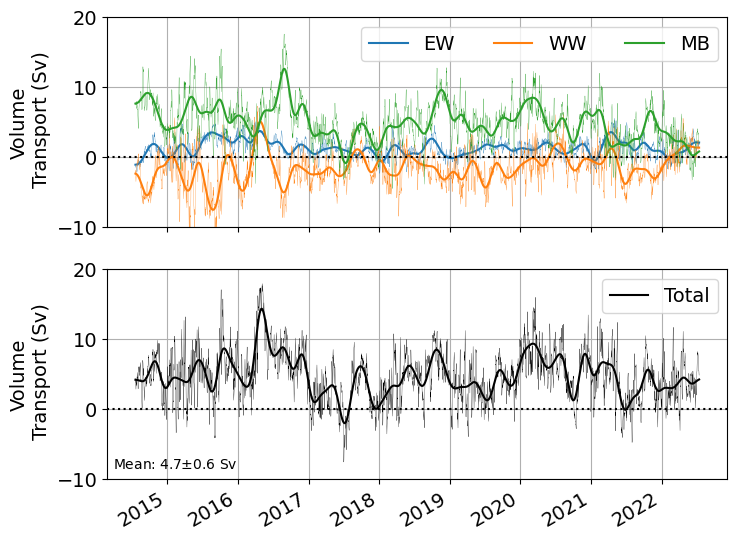

In [10]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Heat Transport

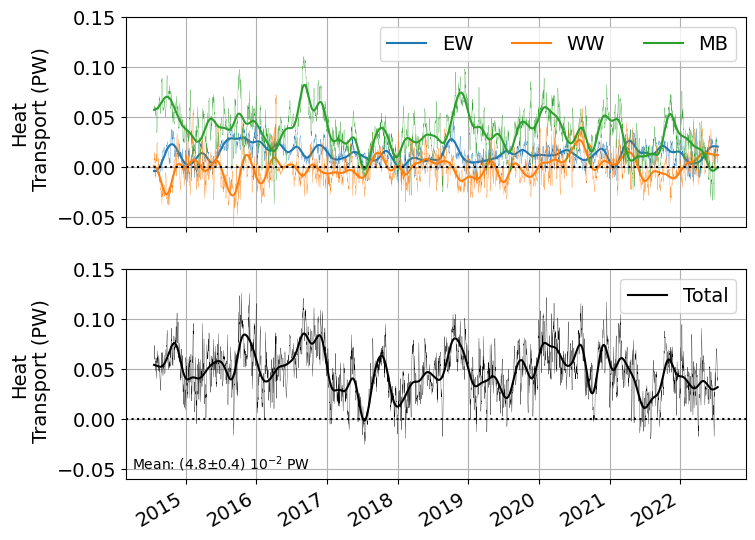

In [11]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

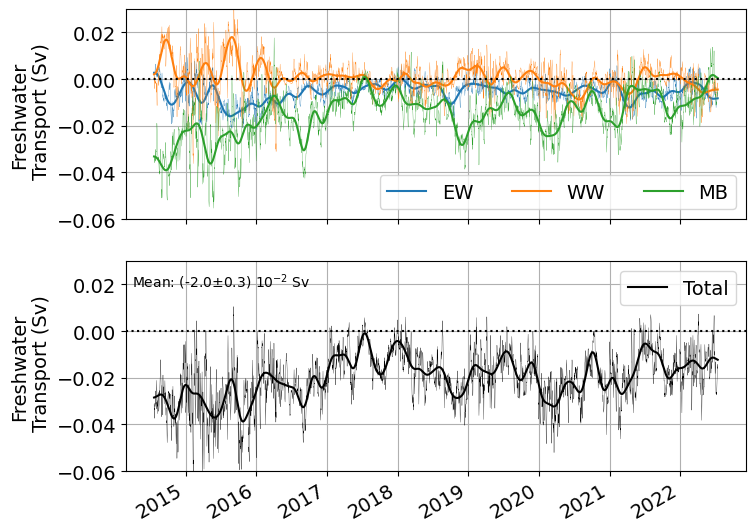

In [12]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Total Transport Timeseries

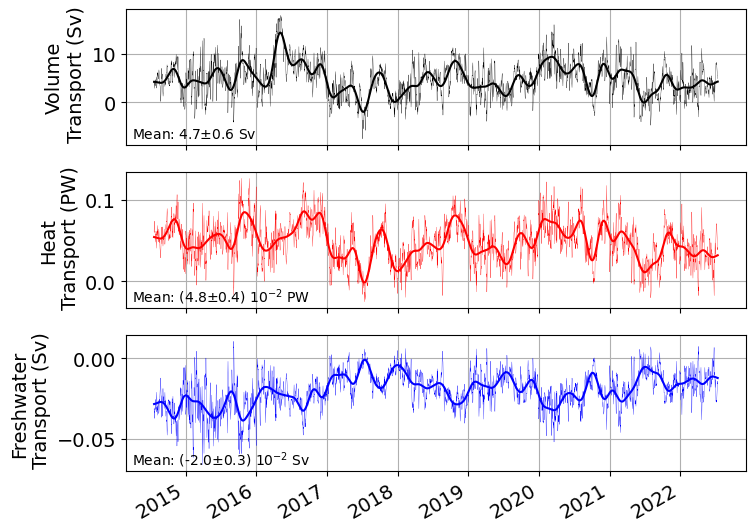

In [13]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values) Q_MB_grid

RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=axs[0],linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=axs[0].transAxes)

RT_Q_Qh_Qf.Qh_tot.plot.line('r',ax=axs[1],linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('r',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

RT_Q_Qh_Qf.Qf_tot.plot.line('b',ax=axs[2],linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('b',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

fig.savefig(f'{fig_out_path}Rockall_Trough_total_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Mean Sections

In [14]:
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')

# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

vel_attrs = {'long_name':'Across section velocity',
                 'units':'m/s'}
CT_attrs = {'long_name':'Conservative temperature',
          'description':'conservative temperature TEOS-10',
          'units':'degC'}
SA_attrs = {'long_name':'Absolute salinity',
        'description':'Absolute salinity TEOS-10',
         'units':'g/kg'}

ds_q_RT.v.attrs = vel_attrs
ds_q_RT.CT.attrs = CT_attrs
ds_q_RT.SA.attrs = SA_attrs

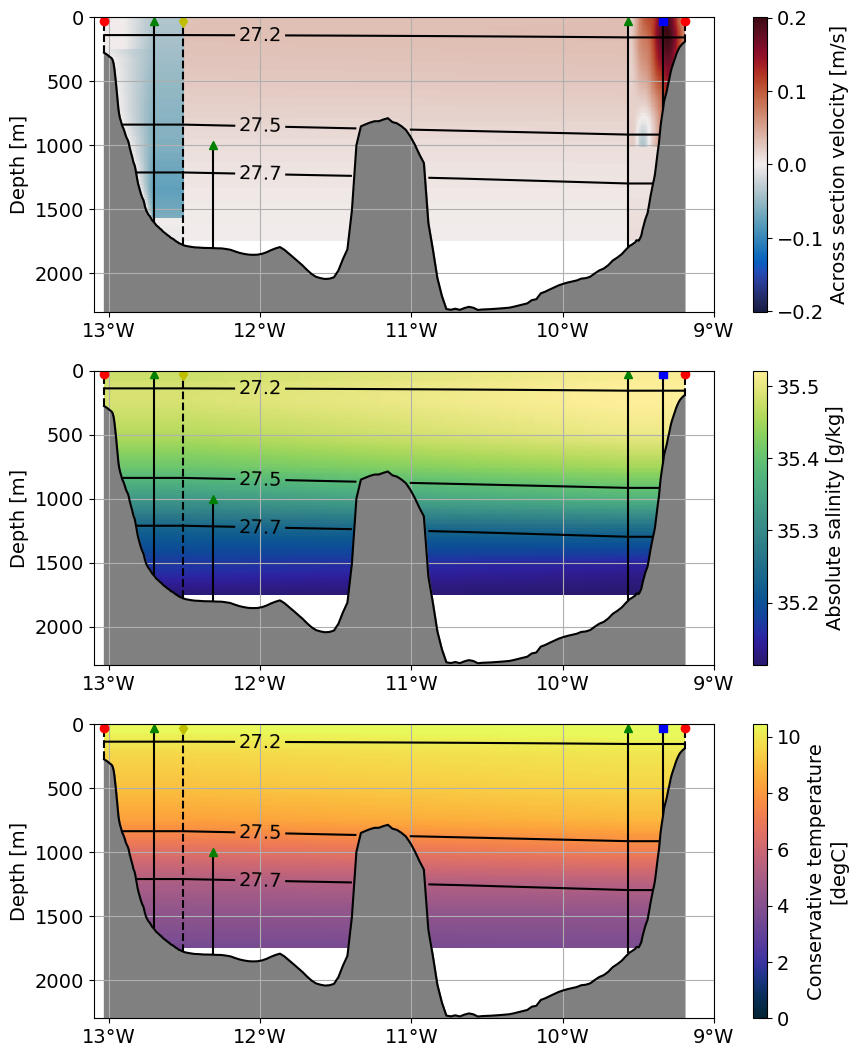

In [15]:
## figure
plt.rcParams.update({'font.size': 14})

xticks = np.arange(-13.,-8,1)
xticklabels = ['13°W','12°W','11°W','10°W','9°W']

sigma_contours = [27.2,27.5, 27.7]
manual_locations = [(-12,100),(-12,900),(-12,1250)]

# Set up figure
fig,axs = plt.subplots(3,1,figsize=[10,13])

ds_q_RT.v.mean('time',keep_attrs=True).plot(ax=axs[0],y='depth',x='lon',yincrease=False,cmap=cm.cm.balance)
ds_q_RT.SA.mean('time',keep_attrs=True).plot(ax=axs[1],y='depth',x='lon',yincrease=False,cmap=cm.cm.haline)
ds_q_RT.CT.mean('time',keep_attrs=True).plot(ax=axs[2],y='depth',x='lon',yincrease=False,cmap=cm.cm.thermal,vmin=0)

for ax in axs:
    ax.fill_between(ds_q_RT.lon, -ds_q_RT.bathy,2300,color='grey')
    (-ds_q_RT.bathy).plot.line('k',ax=ax)
    CS = ds_q_RT.sigma0.mean('time',keep_attrs=True).where(ds_q_RT.depth<=-ds_q_RT.bathy).plot.contour(
        ax=ax,x='lon',levels=sigma_contours,yincrease=False,colors='k')
    ax.clabel(CS,manual=manual_locations)
    
    ax.vlines(RT_loc.lon_RTWB,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(RT_loc.lon_RTES,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(RT_loc.lon_RTWS,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
    
    ax.vlines(RT_loc.lon_RTADCP,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
    ax.vlines(RT_loc.lon_RTEB,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
    ax.vlines(RT_loc.lon_RTWB1,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')
    ax.vlines(RT_loc.lon_RTWB2,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWB2,method='nearest'), 1000,colors='k')
    
    d= 30.
    ax.plot([RT_loc.lon_RTES,RT_loc.lon_RTWS],[d,d],'or')
    ax.plot([RT_loc.lon_RTWB],[d],'dy')
    ax.plot([RT_loc.lon_RTADCP],[d],'sb')
    ax.plot([RT_loc.lon_RTEB,RT_loc.lon_RTWB1],[d,d],'^g')
    ax.plot([RT_loc.lon_RTWB2],[1000],'^g')
    
    ax.set_xlim([-13.1,-9.])
    ax.set_xlabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=14)
    ax.grid()

    ax.set_ylabel('Depth [m]')
    ax.set_ylim([2300,0])

fig.savefig(f'{fig_out_path}Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## EW, WW and glider

In [16]:
fs=18
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

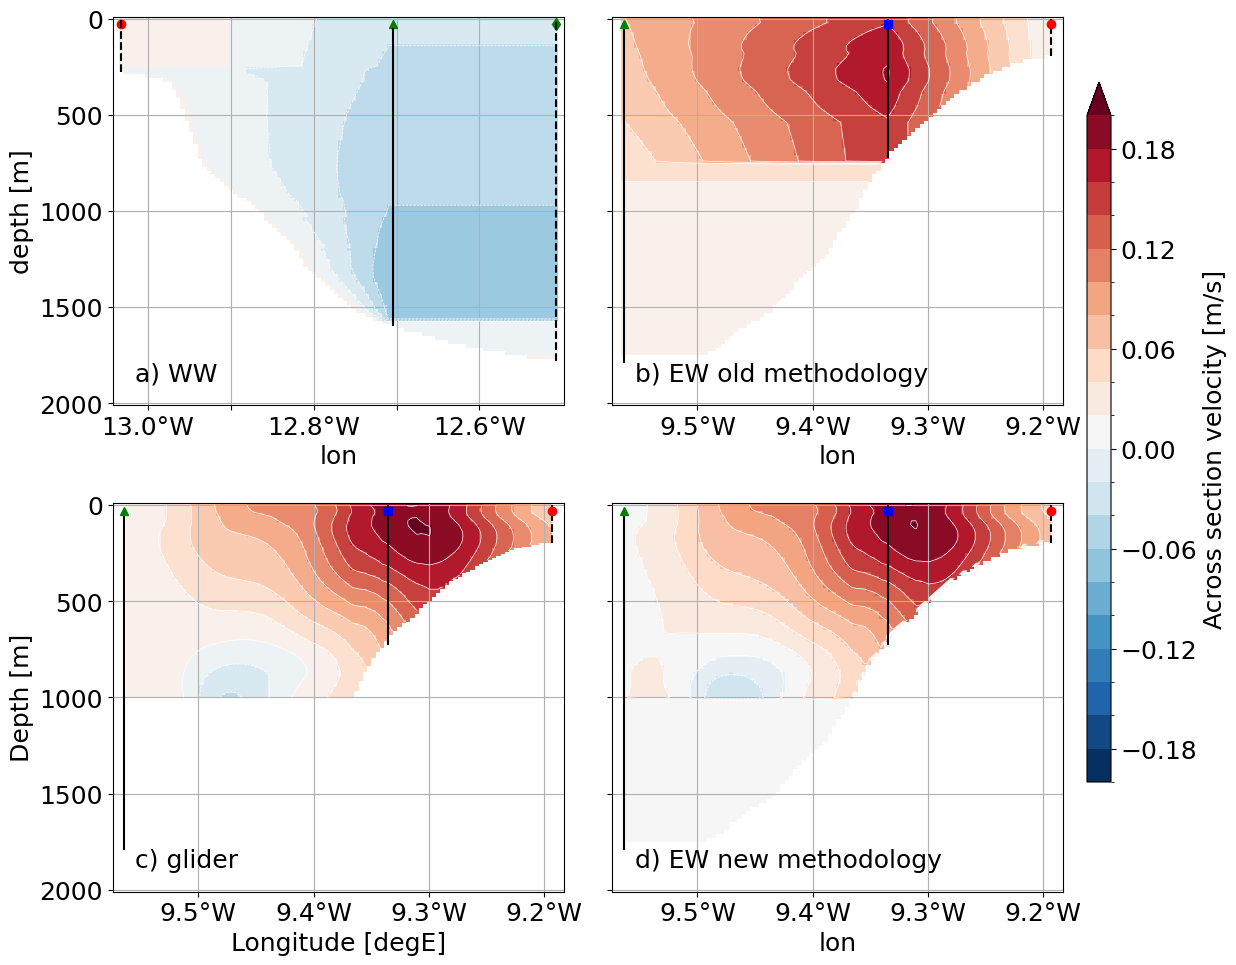

In [17]:
v_glider = ds_glider.vcur
v_glider['depth']=abs(v_glider.depth)

v_old=(ds_q_RTEW_old.q/(ds_q_RTEW_old.dx*ds_q_RTEW_old.dz))
# v_old.mean('time').plot()
# v_glider.interp_like(ds_q_RT.PRES).mean('time').plot()
#WW ds_q_RT.v.sel(lon=ds_q_RTWW.lon).mean('time').plot()
#EW ds_q_RT.v.sel(lon=ds_q_RTEW.lon).mean('time').plot()

xticks_WW = np.arange(-13.,RT_loc.lon_RTWB,.1)
xticklabels_WW = ['13.0°W',' ','12.8°W',' ','12.6°W']

xticks_EW = np.arange(-9.5,RT_loc.lon_RTES,.1)
xticklabels_EW = ['9.5°W','9.4°W','9.3°W','9.2°W']

fig,axs = plt.subplots(2,2,figsize=[12,10],sharey=True)

vmin,vmax,levs=-0.2,0.2,21

ax = axs[0,0]
v = ds_q_RT.v.sel(lon=ds_q_RTWW.lon).mean('time')
v.depth['long_name']='Depth'
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.plot([RT_loc.lon_RTWS],[d],'or')
ax.plot([RT_loc.lon_RTWB],[d],'dg')
ax.plot([RT_loc.lon_RTWB1],[d],'^g')

ax.vlines(RT_loc.lon_RTWB,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
ax.vlines(RT_loc.lon_RTWS,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
ax.vlines(RT_loc.lon_RTWB1,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')

ax.set_xlim([RT_loc.lon_RTWS-0.01,RT_loc.lon_RTWB+0.01])
ax.set_xticks(xticks_WW)
ax.set_xticklabels(xticklabels_WW,fontsize=fs)

ax.text(0.05, 0.05,f'a) WW',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[0,1]
v = v_old.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)

ax.text(0.05, 0.05,f'b) EW old methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[1,0]
v = v_glider.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.05, 0.05,f'c) glider',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[1,1]
v = ds_q_RT.v.sel(lon=ds_q_RTEW.lon).mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.05, 0.05,f'd) EW new methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

for i,ax in enumerate(axs.flat):
    ax.grid()
    if i>0:
        ax.vlines(RT_loc.lon_RTADCP,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
        ax.vlines(RT_loc.lon_RTEB,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
        ax.vlines(RT_loc.lon_RTES,-ds_q_RT.bathy.sel(lon=RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')

        ax.plot([RT_loc.lon_RTES],[d],'or')
        ax.plot([RT_loc.lon_RTADCP],[d],'sb')
        ax.plot([RT_loc.lon_RTEB],[d],'^g')
        
        ax.set_xlim([RT_loc.lon_RTEB-0.01,RT_loc.lon_RTES+0.01])
        ax.set_xticks(xticks_EW)
        ax.set_xticklabels(xticklabels_EW,fontsize=fs)
        
    if i==1 or i==3:
        ax.set_ylabel('')
plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb =fig.colorbar(im_hdl, cax=cbar_ax)
cb.set_label('Across section velocity [m/s]')

fig.savefig(f'{fig_out_path}Rockall_Trough_WW_EW_glider_mean_section_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## RT z-integrated transports

In [18]:
# Compute fluxes in each cell
qh_MB,qf_MB,qS_MB = rtf.calc_fluxes(ds_q_RTMB)
qh_WW,qf_WW,qS_WW = rtf.calc_fluxes(ds_q_RTWW)
qh_EW,qf_EW,qS_EW = rtf.calc_fluxes(ds_q_RTEW)

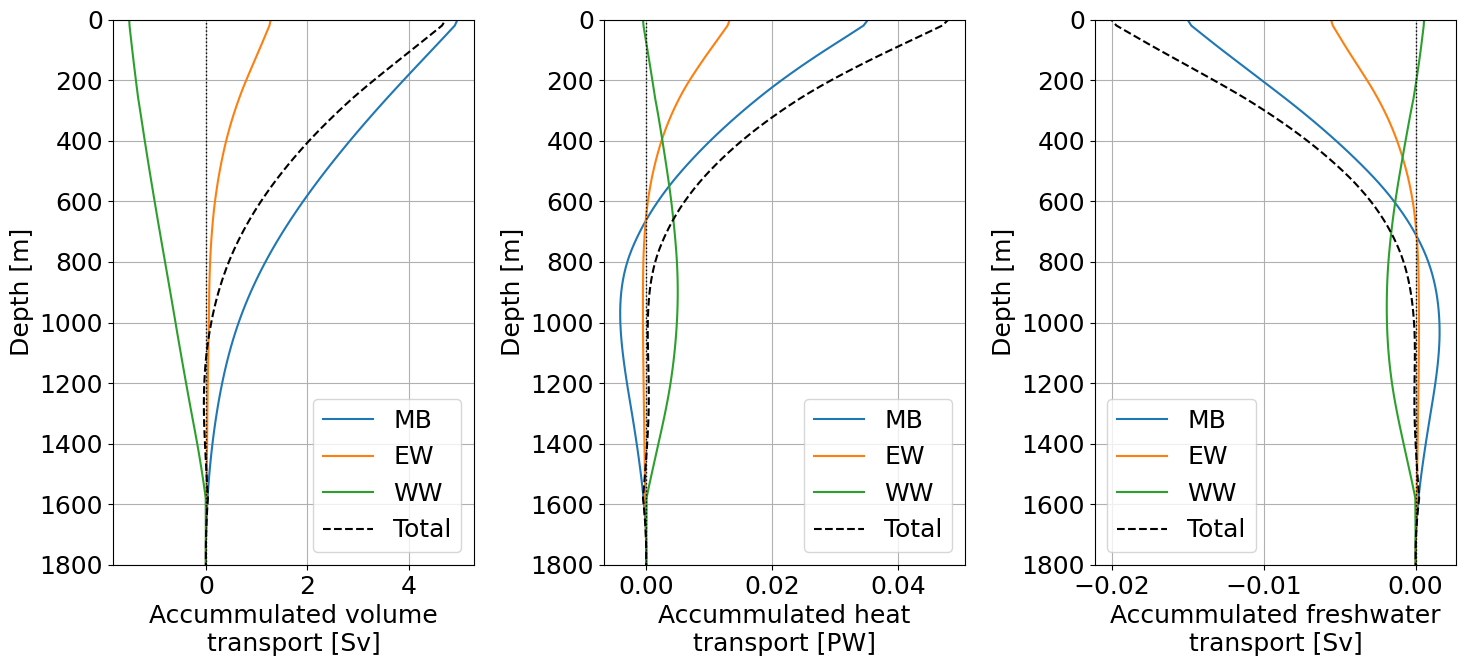

In [19]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_q_RT.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RT.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(qh_MB.sum('lon')/1e15).mean(['time']).reindex(depth=qh_MB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qh_EW.sum('lon')/1e15).mean(['time']).reindex(depth=qh_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qh_WW.sum('lon')/1e15).mean(['time']).reindex(depth=qh_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qh_MB.sum('lon')+qh_WW.sum('lon')+(qh_EW.sum('lon')))/1e15)
total.mean(['time']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(qf_MB.sum('lon')/1e6).mean(['time']).reindex(depth=qf_MB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qf_EW.sum('lon')/1e6).mean(['time']).reindex(depth=qf_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qf_WW.sum('lon')/1e6).mean(['time']).reindex(depth=qf_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qf_MB.sum('lon')+qf_WW.sum('lon')+(qf_EW.sum('lon')))/1e6)
total.mean(['time']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

fig.savefig(f'{fig_out_path}Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')